# Boosting (XGBoost, LightGBM, CatBoost)

In [378]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns

## Feature Engineering

In [379]:
data_train = pd.read_csv('./data/titanic_train.csv')

In [380]:
data_test = pd.read_csv('./data/titanic_test.csv')

In [381]:
nan_values = data_train.isna()
nan_columns = nan_values.any()
nan_columns

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [382]:
nan_values_test = data_test.isna()
nan_columns_test = nan_values_test.any()
nan_columns_test

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

### Age features

In [383]:
age_avg = data_train['Age'].mean()
data_train['Age'] = data_train['Age'].fillna(age_avg)
age_avg = data_test['Age'].mean()
data_test[['Age']] = data_test[['Age']].fillna(age_avg)

In [384]:
data_train['family_s'] = data_train['SibSp'] + data_train['Parch'] + 1
data_test['family_s'] = data_test['SibSp'] + data_test['Parch'] + 1

In [385]:
import jenkspy
from jenkspy import JenksNaturalBreaks
jnb = JenksNaturalBreaks()
jnb.fit(data_train['Age'])
try:
    print(jnb.labels_)
    print(jnb.groups_)
    print(jnb.inner_breaks_)
except:
    pass

[1 3 2 3 3 2 4 0 2 1 0 5 1 3 1 4 0 2 2 2 3 3 1 2 0 3 2 1 2 2 3 2 2 5 2 3 2
 1 1 1 3 2 2 0 1 2 2 2 2 1 0 1 4 2 5 2 1 2 0 0 1 3 4 0 2 2 2 1 1 2 2 1 1 2
 2 2 2 2 0 2 1 2 2 2 1 2 1 2 1 1 2 1 4 2 5 2 5 1 3 3 2 2 1 2 3 2 1 2 3 2 4
 1 1 1 1 1 5 2 1 0 1 2 2 2 4 0 2 1 2 4 2 1 4 2 2 1 1 3 1 1 2 1 1 1 1 1 2 0
 3 3 4 1 4 3 2 4 1 2 2 2 4 3 2 1 0 0 2 4 2 2 5 0 0 1 5 1 2 4 2 3 2 2 0 0 0
 2 2 4 3 3 2 1 1 0 4 5 2 3 2 1 2 2 3 4 1 0 2 2 1 3 1 3 1 2 2 2 2 3 2 2 1 2
 4 2 3 1 1 1 1 2 3 2 5 0 1 2 4 0 1 2 2 2 2 1 2 4 2 1 3 4 2 2 5 2 3 2 2 2 3
 4 2 0 4 3 2 3 1 2 5 3 2 2 3 3 2 5 4 2 0 3 5 2 1 1 2 2 2 1 3 1 2 1 3 1 1 2
 1 0 2 4 2 2 1 2 2 0 2 1 2 2 1 1 2 2 3 2 1 4 2 3 1 2 2 1 2 3 5 3 2 1 2 4 3
 1 2 2 2 3 4 4 0 1 2 2 3 1 3 2 0 3 1 2 1 2 2 2 1 3 2 2 3 2 4 3 2 2 5 2 2 1
 2 1 1 1 0 2 1 2 1 1 3 0 2 3 2 1 0 3 2 1 3 1 2 1 1 1 2 4 1 2 3 2 1 2 1 3 4
 0 1 2 2 2 2 2 4 2 3 1 2 0 2 1 2 2 1 2 2 1 2 2 2 2 3 1 4 1 1 1 5 2 4 1 2 2
 2 0 1 3 0 4 3 2 2 4 2 2 5 2 4 2 4 3 4 4 2 3 2 5 2 0 2 3 2 1 1 2 3 2 1 0 0
 2 4 5 2 2 3 5 2 0 2 1 4 

In [386]:
len(jnb.groups_)

6

In [387]:
#https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
# QCut or “quantile cut” splits based on the number of examples falling into each bucket
data_train['Age'] = pd.qcut(data_train['Age'], 10, duplicates='drop')
data_test['Age'] = pd.qcut(data_test['Age'], 10, duplicates='drop')

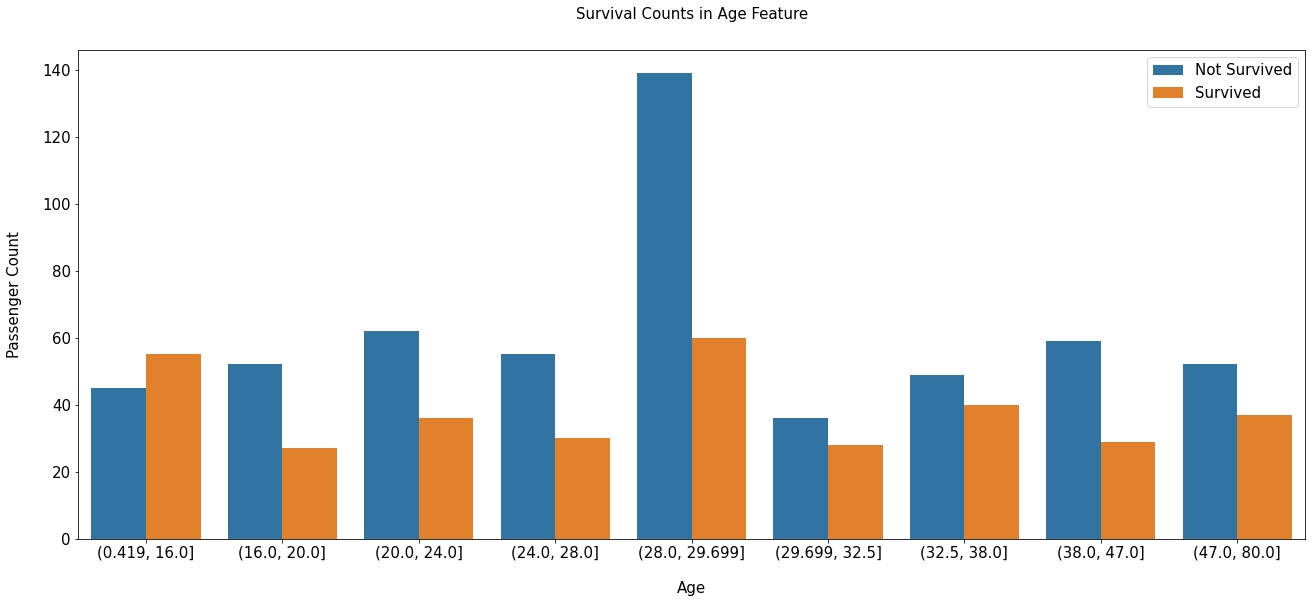

In [388]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=data_train)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### Embarked

In [389]:
data_train[data_train.Embarked.isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_s
61,62,1,1,"Icard, Miss. Amelie",female,"(32.5, 38.0]",0,0,113572,80.0,B28,NaN,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,"(47.0, 80.0]",0,0,113572,80.0,B28,NaN,1


https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html
Both boarded in Southampton

In [390]:
data_train['Embarked'] = data_train['Embarked'].fillna('S')

### Fare

In [391]:
fare_avg = data_test['Fare'].mean()
data_test[['Fare']] = data_test[['Fare']].fillna(fare_avg)

### Ticket

In [392]:
data_train['ticket_group_count'] = data_train.groupby('Ticket')['Ticket'].transform('count')

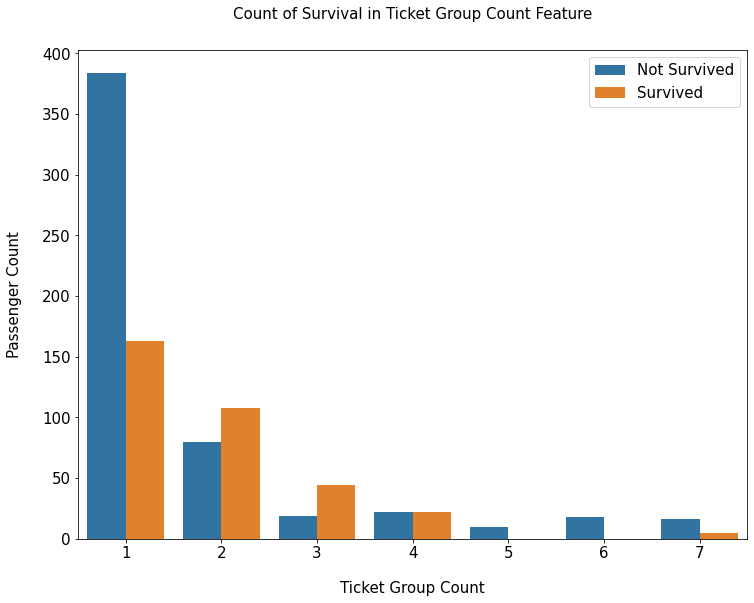

In [393]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='ticket_group_count', hue='Survived', data=data_train)

plt.xlabel('Ticket Group Count', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Group Count'), size=15, y=1.05)

plt.show()

Gropus of peaople have higher survival rate. (we checked passangers with the same tickets). It can be our additional feature

In [394]:
data_test['ticket_group_count'] = data_test.groupby('Ticket')['Ticket'].transform('count')

### Cabin

In [395]:
data_train['cabin_label'] = data_train['Cabin'].str.slice(0,1)
data_train['cabin_label'] = data_train["cabin_label"].fillna("N")
data_test['cabin_label'] = data_test['Cabin'].str.slice(0,1)
data_test['cabin_label'] = data_test['cabin_label'].fillna("N")
data_train['cabin_number'] = data_train["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
data_test['cabin_number'] = data_test["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")

In [396]:
data_test[['cabin_label', 'Cabin']]

,cabin_label,Cabin
0,N,NaN
1,N,NaN
2,N,NaN
3,N,NaN
4,N,NaN
...,...,...
413,N,NaN
414,C,C105
415,N,NaN
416,N,NaN


In [397]:
data_train.drop(columns=['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1, inplace=True)

y_cat = y = data_train.Survived.reset_index(drop=True)

In [398]:
data_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'family_s', 'ticket_group_count', 'cabin_label',
       'cabin_number'],
      dtype='object')

In [399]:
data_test.dtypes

PassengerId              int64
Pclass                   int64
Name                    object
Sex                     object
Age                   category
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                   object
Embarked                object
family_s                 int64
ticket_group_count       int64
cabin_label             object
cabin_number           float64
dtype: object

In [400]:
features = data_train.columns[1:]
features

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'family_s', 'ticket_group_count', 'cabin_label', 'cabin_number'],
      dtype='object')

In [401]:
data_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_s,ticket_group_count,cabin_label,cabin_number
0,0,3,male,"(20.0, 24.0]",1,0,7.2500,S,2,1,N,NaN
1,1,1,female,"(32.5, 38.0]",1,0,71.2833,C,2,1,C,85.0
2,1,3,female,"(24.0, 28.0]",0,0,7.9250,S,1,1,N,NaN
3,1,1,female,"(32.5, 38.0]",1,0,53.1000,S,2,2,C,123.0
4,0,3,male,"(32.5, 38.0]",0,0,8.0500,S,1,1,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,"(24.0, 28.0]",0,0,13.0000,S,1,1,N,NaN
887,1,1,female,"(16.0, 20.0]",0,0,30.0000,S,1,1,B,42.0
888,0,3,female,"(28.0, 29.699]",1,2,23.4500,S,4,2,N,NaN
889,1,1,male,"(24.0, 28.0]",0,0,30.0000,C,1,1,C,148.0


In [402]:
categorical_features = ['Sex', 'Pclass', 'Embarked', 'cabin_label']
ct = make_column_transformer(
        (OneHotEncoder(), categorical_features),
        remainder='passthrough', verbose_feature_names_out=True)
data_transformed = ct.fit_transform(data_train.iloc[:, 1:], y=data_train.Survived)
X = pd.DataFrame(data_transformed, columns=ct.get_feature_names_out())
X = X.astype({"onehotencoder__Sex_female": int,
              "onehotencoder__Sex_male": int,
             "onehotencoder__Pclass_1": int,
             "onehotencoder__Pclass_2": int,
             "onehotencoder__Pclass_3": int,
             "onehotencoder__Embarked_C": int,
             "onehotencoder__Embarked_Q": int,
             "onehotencoder__Embarked_S": int,
             "onehotencoder__cabin_label_A": int,
             "onehotencoder__cabin_label_B": int,
             "onehotencoder__cabin_label_C": int,
             "onehotencoder__cabin_label_D": int,
             "onehotencoder__cabin_label_E": int,
             "onehotencoder__cabin_label_F": int,
             "onehotencoder__cabin_label_G": int,
             "onehotencoder__cabin_label_N": int,
             "onehotencoder__cabin_label_T": int,
             "remainder__SibSp":int,
             "remainder__Parch": int,
             "remainder__Fare": float,
             "remainder__family_s": int,
             "remainder__ticket_group_count" : int,
             "remainder__cabin_number": float
             })
X["remainder__Age"] = LabelEncoder().fit_transform(X["remainder__Age"])
X.dtypes

onehotencoder__Sex_female          int64
onehotencoder__Sex_male            int64
onehotencoder__Pclass_1            int64
onehotencoder__Pclass_2            int64
onehotencoder__Pclass_3            int64
onehotencoder__Embarked_C          int64
onehotencoder__Embarked_Q          int64
onehotencoder__Embarked_S          int64
onehotencoder__cabin_label_A       int64
onehotencoder__cabin_label_B       int64
onehotencoder__cabin_label_C       int64
onehotencoder__cabin_label_D       int64
onehotencoder__cabin_label_E       int64
onehotencoder__cabin_label_F       int64
onehotencoder__cabin_label_G       int64
onehotencoder__cabin_label_N       int64
onehotencoder__cabin_label_T       int64
remainder__Age                     int64
remainder__SibSp                   int64
remainder__Parch                   int64
remainder__Fare                  float64
remainder__family_s                int64
remainder__ticket_group_count      int64
remainder__cabin_number          float64
dtype: object

In [403]:
data_test[features]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_s,ticket_group_count,cabin_label,cabin_number
0,3,male,"(31.9, 39.0]",0,0,7.8292,Q,1,1,N,NaN
1,3,female,"(39.0, 48.0]",1,0,7.0000,S,2,1,N,NaN
2,2,male,"(48.0, 76.0]",0,0,9.6875,Q,1,1,N,NaN
3,3,male,"(24.0, 27.8]",0,0,8.6625,S,1,1,N,NaN
4,3,female,"(21.0, 24.0]",1,1,12.2875,S,3,1,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...
413,3,male,"(27.8, 30.273]",0,0,8.0500,S,1,1,N,NaN
414,1,female,"(31.9, 39.0]",0,0,108.9000,C,1,1,C,105.0
415,3,male,"(31.9, 39.0]",0,0,7.2500,S,1,1,N,NaN
416,3,male,"(27.8, 30.273]",0,0,8.0500,S,1,1,N,NaN


In [404]:
PassengerId = data_test['PassengerId']
test_transformed = ct.fit_transform(data_test[features])
test_transformed = pd.DataFrame(test_transformed, columns=ct.get_feature_names_out())
test_transformed = test_transformed.astype({"onehotencoder__Sex_female": int,
              "onehotencoder__Sex_male": int,
             "onehotencoder__Pclass_1": int,
             "onehotencoder__Pclass_2": int,
             "onehotencoder__Pclass_3": int,
             "onehotencoder__Embarked_C": int,
             "onehotencoder__Embarked_Q": int,
             "onehotencoder__Embarked_S": int,
             "onehotencoder__cabin_label_A": int,
             "onehotencoder__cabin_label_B": int,
             "onehotencoder__cabin_label_C": int,
             "onehotencoder__cabin_label_D": int,
             "onehotencoder__cabin_label_E": int,
             "onehotencoder__cabin_label_F": int,
             "onehotencoder__cabin_label_G": int,
             "onehotencoder__cabin_label_N": int,
             "remainder__SibSp":int,
             "remainder__Parch": int,
             "remainder__Fare": float,
             "remainder__family_s": int,
             "remainder__ticket_group_count" : int,
             "remainder__cabin_number": float
                })
test_transformed["remainder__Age"]= LabelEncoder().fit_transform(test_transformed["remainder__Age"])
test_transformed['onehotencoder__cabin_label_T'] = 0
test_transformed.dtypes

onehotencoder__Sex_female          int64
onehotencoder__Sex_male            int64
onehotencoder__Pclass_1            int64
onehotencoder__Pclass_2            int64
onehotencoder__Pclass_3            int64
onehotencoder__Embarked_C          int64
onehotencoder__Embarked_Q          int64
onehotencoder__Embarked_S          int64
onehotencoder__cabin_label_A       int64
onehotencoder__cabin_label_B       int64
onehotencoder__cabin_label_C       int64
onehotencoder__cabin_label_D       int64
onehotencoder__cabin_label_E       int64
onehotencoder__cabin_label_F       int64
onehotencoder__cabin_label_G       int64
onehotencoder__cabin_label_N       int64
remainder__Age                     int64
remainder__SibSp                   int64
remainder__Parch                   int64
remainder__Fare                  float64
remainder__family_s                int64
remainder__ticket_group_count      int64
remainder__cabin_number          float64
onehotencoder__cabin_label_T       int64
dtype: object

# Xgboost



### Boosting settings

**Explanation after lightgbm theory**<br>
`tree_method` – 'exact' (if you have time, you can try), 'approx', 'hist'(the best choise usually) <br>
`grow_policy` – 'depthwise', 'lossguide' (usually better)<br>
`objective` – default is quite good (sometimes "count:poisson")


### XGBoost parameters tuning

Usually we start tuning parameters with these first: <br>
`n_estimators` - number of boosting rounds, better to use `early_stopping_rounds` <br>
`eta` – learning rate, increasing lr reduces convergence time. (usually default value works good)

### Control Overfitting
When you observe high training accuracy, but low tests accuracy, it is likely that you encounter overfitting problem.

There are in general two ways that you can control overfitting:

* The first way is to directly control model complexity <p>
`max_depth` - maximum depth of a tree, increase of this value will make the model more complex; <br>
`gamma` - minimum loss reduction required to make a further partition on a leaf node of the tree.<br>
`min_child_weight` – minimum sum of instance weight (hessian) needed in a child.


* The second way is to add randomness to make training robust to noise <p>
`subsample` - subsample ratio of the training instance, <br>
`colsample_bytree` - subsample ratio of columns when constructing each tree. <br>


### Handle Imbalanced Dataset
There are two ways to improve it:

* If you care only about the ranking order (AUC) of your prediction
Balance the positive and negative weights, via `scale_pos_weight`
Use AUC for evaluation
* If you care about predicting the right probability
In such a case, you cannot re-balance the dataset. Set parameter `max_delta_step` to a finite number (say 1) will help to converge <br>

More about xgboost parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Always use `early_stopping_round` and tune `n_estimators` on validation.

In [405]:
import xgboost as xgb


parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 4,
    "random_seed": 1,
    "eval_metric": "error"
}


xgb_train = xgb.DMatrix(X, y, feature_names=X.columns)
xgb_test = xgb.DMatrix(test_transformed)

# 0.78229
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 10,
    "random_seed": 1,
    "eval_metric": "error",
    
    # regularization parameters
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "colsample_bylevel":0.8,
    "colsample_bynode":0.7,
    "alpha": 4,
    "max_leaves": 14,

    
    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

In [411]:
# 0.78229
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 10,
    "random_seed": 1,
    "eval_metric": "error",
    
    # regularization parameters
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "colsample_bylevel":0.8,
    "colsample_bynode":0.7,
    "alpha": 4,
    "max_leaves": 14,

    
    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}
num_rounds = 500
results = xgb.cv(parameters, xgb_train, num_rounds, early_stopping_rounds=50,
                 folds=skf, verbose_eval=100)

[0]	train-error:0.20595+0.01169	test-error:0.21886+0.00727
[75]	train-error:0.15600+0.00483	test-error:0.18294+0.02135


In [407]:
parameters['n_estimators'] = 25
clf = xgb.XGBClassifier(**parameters, use_label_encoder=False)
bst = clf.fit(X, y)

In [408]:
bst.best_iteration

24

In [409]:
y_pred = bst.predict(test_transformed)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission_xgboost.csv', index=False)

### Some useful notes

1. Custom objective and evaluation functions – https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
2. Never use timeseries validation with **xgb.cv**, it is broken :( 
3. Investigate your task and metrics. There are many objective functions that are worth to try.
